# Backpropagation

Loading data

In [ ]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
from mpmath import mp
import math

with open('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 19/data.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.shape)
X = data[:, :5]
y = data[:, -1]

Mounted at /content/drive/
(506, 6)


## Implementing Forward propagation, Backpropagation and Gradient checking

### Forward propagation

In [ ]:
def sigmoid(z):
  if type(z) == list or isinstance(z,np.ndarray):
    return np.array([1/(1+ float(mp.exp(-i))) for i in z])
  else:
    return 1/(1+ float(mp.exp(-z)))

In [ ]:
def forward_propagation(x, y, w):
    # calculate values across nodes for forward propagation
    val_1   = (w[0]*x[0]+w[1]*x[1]) * (w[0]*x[0]+w[1]*x[1]) + w[5]
    exp     = np.exp(val_1)
    val_2   = exp+w[6]
    tanh    = math.tanh(val_2)
    val_31  = (math.sin(w[2]*x[2]) * ((w[3]*x[3])+(w[4]*x[4])))
    val_32  = (math.sin(w[2]*x[2]) * ((w[3]*x[3])+(w[4]*x[4]))) + w[7]
    sig     = sigmoid(val_32)
    y_pred  = tanh + (w[8]*sig)
    loss    = (y-y_pred)**2
    dy_pred = -2*(y-y_pred)

    # calculate derivatives for backward propagation
    dw9 = sig * dy_pred
    dw8 = sigmoid(val_32) * (1-sigmoid(val_32)) * dy_pred * w[8]
    dw7 = dy_pred * (1-(math.tanh(val_2))**2)
    dw6 = dw7 * np.exp(val_1)
    dw5 = x[4] * dw8 * math.sin(w[2]*x[2])
    dw4 = x[3] * dw8 * math.sin(w[2]*x[2])
    dw3 = dw8 * (w[3]*x[3] + w[4]*x[4]) * math.cos(w[2]*x[2]) * x[2]
    dw2 = x[1] * 2 * dw6 * (w[0]*x[0] + w[1]*x[1])
    dw1 = x[0] * 2 * dw6 * (w[0]*x[0] + w[1]*x[1])

    # store the forward propagation values and derivaties into a dictionary
    forward_dict={}
    forward_dict['exp']     = exp
    forward_dict['sigmoid'] = sig
    forward_dict['tanh']    = tanh
    forward_dict['loss']    = loss
    forward_dict['dy_pred'] = dy_pred

    forward_dict['w0'] = w[0]
    forward_dict['w1'] = w[1]
    forward_dict['w2'] = w[2]
    forward_dict['w3'] = w[3]
    forward_dict['w4'] = w[4]
    forward_dict['w5'] = w[5]
    forward_dict['w6'] = w[6]
    forward_dict['w7'] = w[7]
    forward_dict['w8'] = w[8]

    forward_dict['dw1'] = dw1
    forward_dict['dw2'] = dw2
    forward_dict['dw3'] = dw3
    forward_dict['dw4'] = dw4
    forward_dict['dw5'] = dw5
    forward_dict['dw6'] = dw6
    forward_dict['dw7'] = dw7
    forward_dict['dw8'] = dw8
    forward_dict['dw9'] = dw9

    return forward_dict

### Backward propagation

In [ ]:
def backward_propagation(x,y,w,forward_dict):
    # store the back propagation values to a dictionary
    backward_dict={}
    backward_dict['dw1'] = forward_dict['dw1']
    backward_dict['dw2'] = forward_dict['dw2']
    backward_dict['dw3'] = forward_dict['dw3']
    backward_dict['dw4'] = forward_dict['dw4']
    backward_dict['dw5'] = forward_dict['dw5']
    backward_dict['dw6'] = forward_dict['dw6']
    backward_dict['dw7'] = forward_dict['dw7']
    backward_dict['dw8'] = forward_dict['dw8']
    backward_dict['dw9'] = forward_dict['dw9']
    return backward_dict

### Gradient clipping

In [ ]:
def gradient_checking(x,y,w,eps):
    # do forward propagation and back propagation and store the values
    forward_dict=forward_propagation(x,y,w)
    backward_dict=backward_propagation(x,y,w,forward_dict)
    original_gradients_list=list(backward_dict.values())

    df = {}
    db = {}
    approx_gradients_list=[]
    # add noise to weights and do approximation for gradient checking
    for i in range(0, len(w)):
      w[i] = w[i] + eps
      df = forward_propagation(x,y,w)
      bd = backward_propagation(x,y,w,df)
      approx_gradients_list.append(bd['dw' + str(i+1)])
    original_gradients_list=np.array(original_gradients_list)
    approx_gradients_list=np.array(approx_gradients_list)
    gradient_check_value =(original_gradients_list-approx_gradients_list)/(original_gradients_list+approx_gradients_list)

    return gradient_check_value

## Optimizers

### Algorithm with Vanilla update of weights

In [ ]:
# function to do optimization based on weight updates and plot results
def optimize_network_Vanilla(X,y,lr,epochs):
  w = np.random.normal(loc=0,scale=0.01,size=(1,9))[0]
  loss_dict = {}
  for i in range(epochs):
    for j in range(len(X)):
      if (i==0) and (j==0):
        forward_dict=forward_propagation(X[j],y[j],w)
        backward_dict=backward_propagation(X[j],y[j],w,forward_dict)
      for k in range(len(w)):
        # doing SGD - Vanilla update of weights
        forward_dict['w' + str(k)] = forward_dict['w' + str(k)] - (lr * backward_dict['dw' + str(k+1)])
      forward_dict=forward_propagation(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))])
      backward_dict=backward_propagation(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))],forward_dict)
    loss_dict[i] = forward_dict['loss']
  print('Optimizer: Vanilla, Best loss:', format(min(loss_dict.values()),'.10f'),', epoch:',min(loss_dict, key=loss_dict.get))
  return loss_dict

lr = 0.0001
epochs = 100
loss_dict_Vanilla = optimize_network_Vanilla(X,y,lr,epochs)

Optimizer: Vanilla, Best loss: 0.0000109655 , epoch: 43


### Algorithm with Momentum update of weights

In [ ]:
def forward_prop_Momentum(x, y, w, v):
    forward_dict=forward_propagation(x,y,w)
    forward_dict['v'] = v
    return forward_dict

In [ ]:
# function to do optimization based on weight updates and plot results
def optimize_network_Momentum(X,y,lr,gamma,epochs):
  w = np.random.normal(loc=0,scale=0.01,size=(1,9))[0]
  v = np.zeros((1,9))[0]
  loss_dict = {}
  for i in range(epochs):
    for j in range(len(X)):
      if (i==0) and (j==0):
        forward_dict=forward_prop_Momentum(X[j],y[j],w,v)
        backward_dict=backward_propagation(X[j],y[j],w,forward_dict)
      for k in range(len(w)):
        # doing Momentum update of weights
        forward_dict['v'][k] = gamma * forward_dict['v'][k] + lr * backward_dict['dw' + str(k+1)]
        forward_dict['w' + str(k)] = forward_dict['w' + str(k)] - forward_dict['v'][k]
      forward_dict=forward_prop_Momentum(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))],forward_dict['v'])
      backward_dict=backward_propagation(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))],forward_dict)
    loss_dict[i] = forward_dict['loss']
  print('Optimizer: Momentum, Best loss:', format(min(loss_dict.values()),'.10f'),', epoch:',min(loss_dict, key=loss_dict.get))
  return loss_dict

lr = 0.0001
gamma = 0.9
epochs = 100
loss_dict_Momentum = optimize_network_Momentum(X,y,lr,gamma,epochs)

Optimizer: Momentum, Best loss: 0.0006339288 , epoch: 3


### Algorithm with Adam update of weights

In [ ]:
def forward_prop_Adam(x, y, w, m, v):
    forward_dict=forward_propagation(x,y,w)
    forward_dict['m'] = m
    forward_dict['v'] = v
    return forward_dict

In [ ]:
# Adam update of weights
# function to do optimization based on weight updates and plot results
def optimize_network_Adam(X,y,lr,beta1,beta2,epsilon,epochs):
  w = np.random.normal(loc=0,scale=0.01,size=(1,9))[0]
  m = np.zeros((1,9))[0]
  v = np.zeros((1,9))[0]
  loss_dict = {}
  for i in range(epochs):
    for j in range(len(X)):
      if (i==0) and (j==0):
        forward_dict=forward_prop_Adam(X[j],y[j],w,m,v)
        backward_dict=backward_propagation(X[j],y[j],w,forward_dict)
      # finding incremental time steps - t for each of the weight updates
      t = (i+1) * (j+1)
      #w = [forward_dict['w' + str(i)] for i in range(len(w))]
      for k in range(len(w)):
        # doing Adam update of weights
        forward_dict['m'][k] = (beta1 * forward_dict['m'][k]) + (1-beta1) * backward_dict['dw' + str(k+1)]
        forward_dict['v'][k] = (beta2 * forward_dict['v'][k]) + (1-beta2) * (backward_dict['dw' + str(k+1)])**2
      for l in range(len(w)):
        forward_dict['w' + str(l)] = forward_dict['w' + str(l)] - (((lr*forward_dict['m'][k] / (1-beta1**t))/np.sqrt((forward_dict['v'][k] / (1-beta2**t))+epsilon)))
      forward_dict=forward_prop_Adam(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))],forward_dict['m'],forward_dict['v'])
      backward_dict=backward_propagation(X[j],y[j],[forward_dict['w' + str(i)] for i in range(len(w))],forward_dict)
    loss_dict[i] = forward_dict['loss']
  print('Optimizer: Adam, Best loss:', format(min(loss_dict.values()),'.10f'),', epoch:',min(loss_dict, key=loss_dict.get))
  return loss_dict

lr = 0.0001
beta1 = 0.95
beta2 = 0.95
epsilon = 0.0000001
epochs = 100
loss_dict_Adam = optimize_network_Adam(X,y,lr,beta1,beta2,epsilon,epochs)

Optimizer: Adam, Best loss: 0.0000097001 , epoch: 20


### Comparision plot between epochs and loss with different optimizers

Optimizer: Vanilla, Best loss: 0.0000000630 , epoch: 43
Optimizer: Momentum, Best loss: 0.0005938532 , epoch: 3
Optimizer: Adam, Best loss: 0.0000033286 , epoch: 99


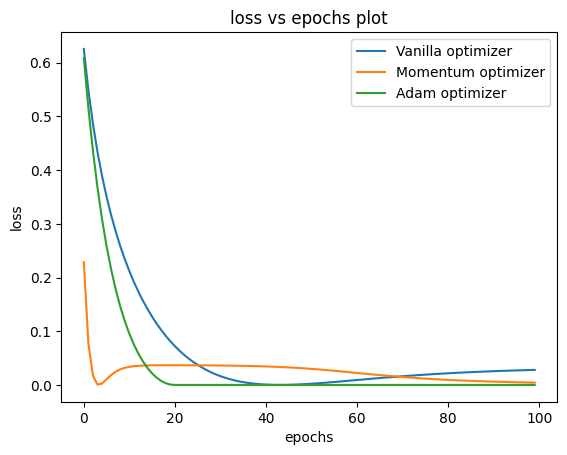

In [ ]:
# define huperparameters for all of the 3 optimizers
lr = 0.0001
epochs = 100
gamma = 0.9
beta1 = 0.95
beta2 = 0.95
epsilon = 0.0000001

# plot loss versus epochs for all of the 3 optimizers for comparison
loss_dict_Vanilla = optimize_network_Vanilla(X,y,lr,epochs)
plt.plot(loss_dict_Vanilla.keys(),loss_dict_Vanilla.values(),label='Vanilla optimizer')
loss_dict_Momentum = optimize_network_Momentum(X,y,lr,gamma,epochs)
plt.plot(loss_dict_Momentum.keys(),loss_dict_Momentum.values(),label='Momentum optimizer')
loss_dict_Adam = optimize_network_Adam(X,y,lr,beta1,beta2,epsilon,epochs)
plt.plot(loss_dict_Adam.keys(),loss_dict_Adam.values(),label='Adam optimizer')

plt.title('loss vs epochs plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Observations

- Vanilla and Adam optimizers converges gradually for increasing epochs.
- For Momentum optimizer the optimization happens quickly in 3 epochs and then there is a difflection in loss in the -ve direction.
- Vanilla optimizer gives the best loss - 0.0000045190 in 43 epochs.
- Considering the overall performance, the Adam optimizer perform gives the best result. Adam optimizer converges in less epochs and keep consistency in convergence.